In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time

In [71]:
df = yf.download( tickers = "AAPL", period = "14d", interval = "15m", group_by = 'ticker', auto_adjust = True, prepost = True, threads = True, proxy = None)
df = df.reset_index()
unix = lambda time_: int((time.mktime(time_.timetuple())))
df['time'] = df['Datetime'].map(unix)
df = df[['time', 'High']]
df.set_index('time')
df.head()

[*********************100%***********************]  1 of 1 completed


,time,High
0,1674036000,136.28
1,1674036900,136.33
2,1674037800,136.20
3,1674038700,136.25
4,1674039600,136.25


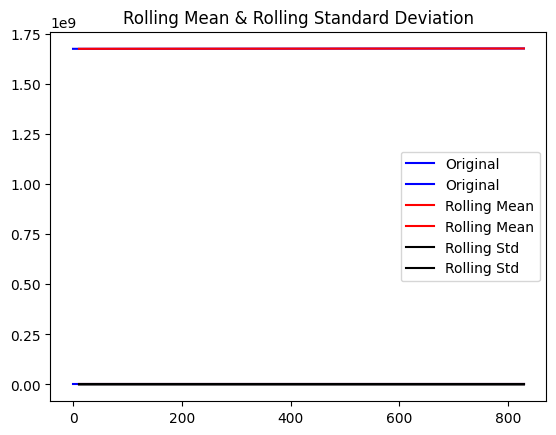

In [72]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

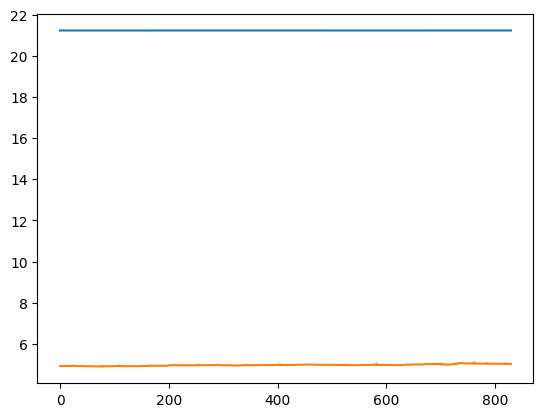

In [73]:
df_log = np.log(df)
plt.plot(df_log)

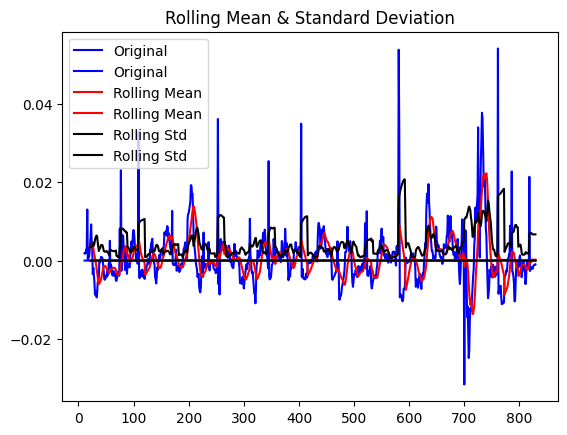

ADF Statistic: -8.160861319738892
p-value: 9.15191717598702e-13
Critical Values:
	1%: -3.438399099271788
	5%: -2.8650928286782857
	10%: -2.568661836350634


In [74]:
def get_stationarity(timeseries):

    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    # COLUMN NAME
    result = adfuller(timeseries['High'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

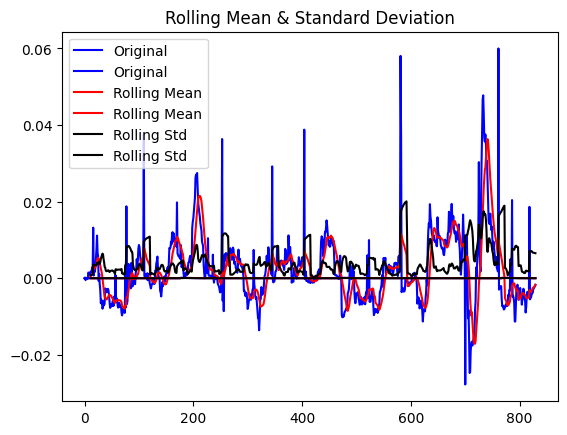

ADF Statistic: -5.681391744866499
p-value: 8.470255767616537e-07
Critical Values:
	1%: -3.4382915719823934
	5%: -2.8650454292904577
	10%: -2.568636586835826


In [75]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

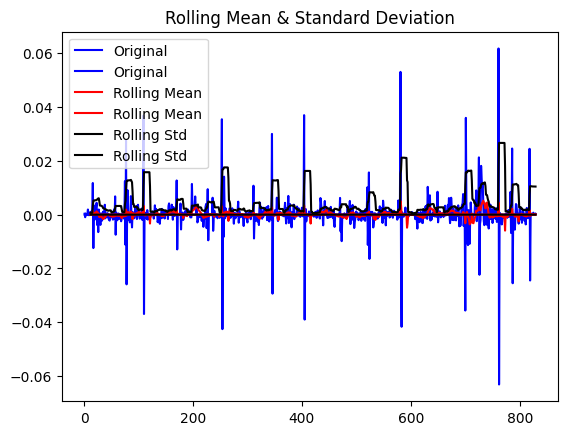

ADF Statistic: -19.14254892556654
p-value: 0.0
Critical Values:
	1%: -3.438301228330467
	5%: -2.865049685999388
	10%: -2.5686388543618


In [76]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [83]:
decomposition = seasonal_decompose(df_log)
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

TypeError: len() of unsized object